# Tribolium embryo morphometry
Authors: Robert Haase, Daniela Vorkel, June 2020

This is the pyclesperanto version of a workflow earlier [published for clij2](https://clij.github.io/clij2-docs/md/tribolium_morphometry/). 
[ImageJ Macro original](https://github.com/clij/clij2-docs/tree/master/src/main/macro/tribolium_morphometry.ijm)

This script is an example of heavy GPU-accelerated processing. It is recommended to use a dedicated
graphics card with at least 8 GB of GDDR6 memory. Otherwise, it may be quite slow.

Let's start by checking that pyclesperanto is installed and which GPU it uses.

In [1]:
import pyclesperanto_prototype as cle

cle.select_device('RTX')

<Apple M1 Max on Platform: Apple (2 refs)>

## Load a data set
The dataset is available [online](https://git.mpi-cbg.de/rhaase/clij2_example_data/blob/master/lund1051_resampled.tif).
It shows a *Tribolium castaneum* embryo, imaged by a custom light sheet microscope, at a wavelength of 488nm (Imaging credits: Daniela Vorkel, Myers lab, MPI CBG). 
The data set has been resampled to a voxel size of 1x1x1 microns. The embryo expresses nuclei-GFP. We will use the dataset to detect nuclei and to generate an estimated cell-segmentation.

All processing steps are performed in 3D space. For visualization purpose, we are using the maximum intensity projection in Z: 

In [2]:
from skimage.io import imread

# load data (download it from https://git.mpi-cbg.de/rhaase/clij2_example_data/-/blob/master/lund1051_resampled.tif
image = imread('../napari_gui/lund1051_resampled.tif')

# print out the spatial dimensions of the image
print(image.shape)

(213, 710, 355)


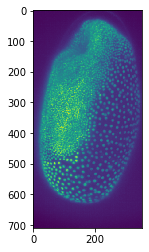

In [3]:
cle.imshow(image)

## Spot detection
After some noise removal/smoothing, we perform a local maximum detection:

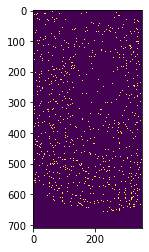

In [4]:
# gaussian blur
sigma = 2.0
blurred = cle.gaussian_blur(image, sigma_x=sigma, sigma_y=sigma, sigma_z=sigma)

# detect maxima
detected_maxima = cle.detect_maxima_box(blurred)
cle.imshow(detected_maxima)

## Spot curation
Now, we remove spots with values below a certain intensity and label the remaining spots.

In [5]:
# threshold
threshold = 300.0
thresholded = cle.greater_constant(blurred, constant=threshold)

# mask
masked_spots = cle.mask(detected_maxima, thresholded)

# label spots
labelled_spots = cle.connected_components_labeling_box(masked_spots)

Let's see how many spots are left:

In [6]:
number_of_spots = cle.maximum_of_all_pixels(labelled_spots)
print("Number of detected spots: " + str(number_of_spots))

Number of detected spots: 1650.0


## Expanding labelled spots
Next, we spatially extend the labelled spots by applying a maximum filter.

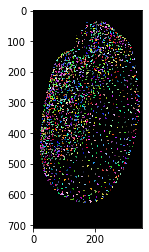

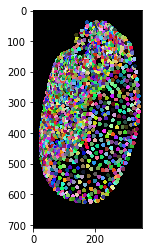

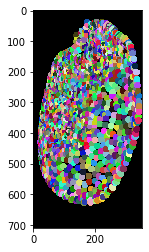

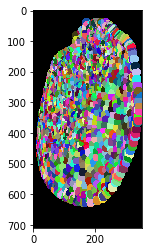

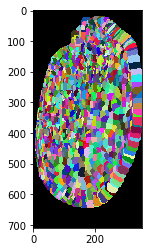

In [7]:
# label map closing
number_of_dilations = 10
number_of_erosions = 4

flip = cle.create_labels_like(labelled_spots)
flop = cle.create_labels_like(labelled_spots)
flag = cle.create([1,1,1])
cle.copy(labelled_spots, flip)

for i in range (0, number_of_dilations) :
    cle.onlyzero_overwrite_maximum_box(flip, flag, flop)
    cle.onlyzero_overwrite_maximum_diamond(flop, flag, flip)
    if (i % 2 == 0):
        cle.imshow(flip, labels=True)

Afterwards, we erode all labels in the map and get a final result of cell segementation.

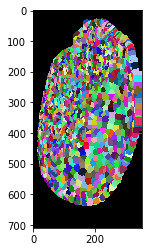

In [8]:
flap = cle.greater_constant(flip, constant = 1)
for i in range(0, number_of_erosions):
    cle.erode_box(flap, flop)
    cle.erode_box(flop, flap)

labels = cle.mask(flip, flap)
cle.imshow(labels, labels=True)

## Draw connectivity of the cells as a mesh
We then read out all current positions of detected nuclei as a pointlist to generate 
a distance matrix of all nuclei towards each other:

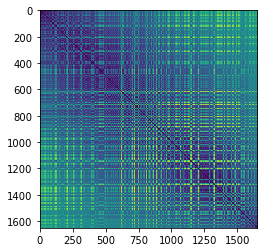

In [9]:
pointlist = cle.labelled_spots_to_pointlist(labelled_spots)
distance_matrix = cle.generate_distance_matrix(pointlist, pointlist)
cle.imshow(distance_matrix)

Starting from the label map of segmented cells, we generate a touch matrix:

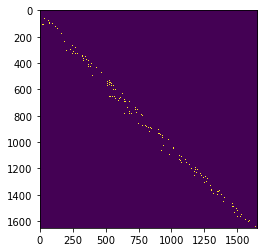

In [10]:
touch_matrix = cle.generate_touch_matrix(labels)

# touch matrix:
# set the first column to zero to ignore all spots touching the background (background label 0, first column)
cle.set_column(touch_matrix, 0, 0)

cle.imshow(touch_matrix)

Using element by element multiplication of a distance matrix and a touch matrix, we calculate the length of 
each edge. We use this result to draw a mesh with a color gradient of distance (between 0 and 50 micron):

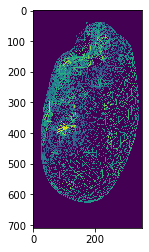

In [11]:
touch_matrix_with_distances = cle.multiply_images(touch_matrix, distance_matrix);

mesh = cle.create_like(blurred)
cle.set(mesh, 0)

cle.touch_matrix_to_mesh(pointlist, touch_matrix_with_distances, mesh);

cle.imshow(mesh)

## Short cut
As this procedure is a bit complicated, you can also get a distance mesh directly from the label image.

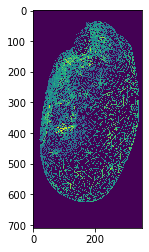

In [12]:
mesh2 = cle.draw_distance_mesh_between_touching_labels(labels)
cle.imshow(mesh2)